# Training a Convolutional Neural Network (CNN) for Handwriting Word Recognition

## Overview
This Jupyter notebook demonstrates how to train a simple **Convolutional Neural Network (CNN)** to recognize handwritten words. The goal is to utilize fundamental deep learning techniques to classify handwritten words accurately.

### The scheme to implement a model with keras:

* Architecture of the model
* Compiling the model
* Training of the model Diagnosis of the training
* Evaluation of predictions


## Importing Required Libraries

In this section, we import all the necessary libraries and modules. These libraries are used for tasks like data manipulation, image processing, deep learning model creation, and evaluation. The imports are organized based on their functionality.


In [2]:
# Data Handling
import pandas as pd
import numpy as np
import os

# Image Processing
import cv2
from PIL import Image

# Deep Learning Frameworks (TensorFlow & Keras)
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

# Plotting and Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

# Progress Bar
from tqdm import tqdm

# NLP Utility to Import Stopwords Listimport nltk
import nltk
from nltk.corpus import stopwords

## Loading and Preprocessing Dataset

In this section, we load the handwritten text dataset from a specified directory and create a structured dataset that combines image paths with their corresponding transcription labels. We also verify the availability of image files to filter out corrupted or missing entries.

- **Dataset Path**: We define the root path to the image dataset.
- **Word Transcriptions**: We read the `words.txt` file, which contains metadata about the handwritten samples, including file names and corresponding transcriptions.
- **Data Integrity Check**: We ensure that all referenced images exist and are not corrupted. Invalid entries are counted.

In [87]:
# Define the dataset path
dataset_path = '../../words'  # Update this path based on your specific directory structure

# Initialize data list and load transcription file
data = []  # List to store dataset information
words = open("../ascii/words.txt", "r").readlines()  # Read the words.txt file which contains metadata for each image
inexistent_or_corrupted = 0  # Counter for inexistent or corrupted image files

# Iterate over each line of the metadata file
for line in tqdm(words):
    if line.startswith("#"):  # Skip header lines that start with '#'
        continue

    # Split the line into different components
    parts = line.strip().split()
    fixed_part = parts[:8]  # Extract fixed part of the metadata (e.g., ID, coordinates, etc.)
    transcription_part = ' '.join(parts[8:])  # Extract the transcription part (actual word)

    # Construct folder paths and image file names
    line_split = line.split(" ")
    folder_parts = line_split[0].split('-')
    folder1 = folder_parts[0]
    folder2 = folder_parts[0] + '-' + folder_parts[1]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')

    # Construct the relative path for the image
    rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

    # Check if the image exists and is not corrupted (file size > 0)
    if os.path.exists(rel_path) and os.path.getsize(rel_path) > 0:
        # Append metadata and image path to data list
        data.append(fixed_part + [transcription_part, rel_path])
    else:
        # Increment counter if image is missing or corrupted
        inexistent_or_corrupted += 1

# Print the count of inexistent or corrupted images
print('Number of inexistent or corrupted files:', inexistent_or_corrupted)

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['line_id', 'result', 'graylevel', 'x', 'y', 'w', 'h', 'annotation', 'transcription', 'image_path'])
display(df.head())  # Display the first few rows of the DataFrame


100%|██████████| 115338/115338 [00:20<00:00, 5648.98it/s]


Number of inexistent or corrupted files: 2


,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../words\a01\a01-000u\a01-000u-00-00.png
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../words\a01\a01-000u\a01-000u-00-01.png
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../words\a01\a01-000u\a01-000u-00-02.png
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../words\a01\a01-000u\a01-000u-00-03.png
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../words\a01\a01-000u\a01-000u-00-04.png


## Interactive Visualization of Transcription Frequency Distribution

Before applying any filtering, it is helpful to visualize the distribution of transcription frequencies. This plot provides insights into the number of times each transcription appears in the dataset, helping us understand which classes might be overrepresented or underrepresented.

This plot includes several interactive features:
- **Hover Tooltips**: Hover over the data points to see detailed information.
- **Zoom Options**: Use mouse controls to zoom in and out of specific areas of the plot.
- **Toggle Axis Type**: The plot has buttons to toggle between linear and log scales for both axes, making it easier to explore the distribution.

In [88]:
# Prepare the data for Plotly
transcription_counts = df['transcription'].value_counts()
frequency_counts = transcription_counts.value_counts().sort_index()

# Create a figure using Plotly
fig = go.Figure()

# Add scatter trace for the data points
fig.add_trace(go.Scatter(
    x=frequency_counts.index, 
    y=frequency_counts.values, 
    mode='markers+lines',
    marker=dict(size=6, color='red'),
    name='Frequency of Transcriptions',
    hoverinfo='x+y'
))

# Update axis labels and title
fig.update_layout(
    title='Frequency of Repetitions of Transcriptions',
    xaxis=dict(
        title='Number of Occurrences of Transcription',
        type='log',  # Initially set to log scale
    ),
    yaxis=dict(
        title='Frequency (Count of Transcriptions)',
        type='log',  # Initially set to log scale
    ),
    xaxis_title='Number of Occurrences of Transcription',
    yaxis_title='Frequency (Count of Transcriptions)',
    hovermode='closest'
)

# Add buttons to switch between log and linear scales
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=list([
                dict(
                    args=[{"xaxis.type": "log", "yaxis.type": "log"}],
                    label="Log-Log Scale",
                    method="relayout"
                ),
                dict(
                    args=[{"xaxis.type": "linear", "yaxis.type": "linear"}],
                    label="Linear Scale",
                    method="relayout"
                ),
                dict(
                    args=[{"xaxis.type": "log", "yaxis.type": "linear"}],
                    label="Log X - Linear Y",
                    method="relayout"
                ),
                dict(
                    args=[{"xaxis.type": "linear", "yaxis.type": "log"}],
                    label="Linear X - Log Y",
                    method="relayout"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)

# Show the plot
fig.show()


## Filtering Transcriptions by Frequency

To improve the quality and balance of the dataset, we filter the transcriptions based on their frequency. Transcriptions that occur either too frequently or too rarely can lead to imbalance or overfitting during model training. In this section, we:

1. Set a range for transcription frequency.
2. Filter the dataset to keep only transcriptions that fall within the desired range.
3. Reset the index to ensure the filtered DataFrame has a clean, continuous index.
4. Print the unique transcriptions in the filtered dataset to verify the diversity.

In [89]:
# Set the minimum and maximum sample counts for filtering transcriptions
min_samples = 100  # Minimum number of occurrences for a transcription to be included
max_samples = 200  # Maximum number of occurrences for a transcription to be included

# Filter transcriptions based on the specified count thresholds
class_counts = df['transcription'].value_counts()  # Get the count of each transcription
classes_to_keep = class_counts[(class_counts >= min_samples) & (class_counts <= max_samples)].index  # Identify transcriptions to retain
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()  # Create a filtered DataFrame containing only the selected transcriptions

# Reset index after filtering to ensure a clean, continuous index
df_filtered.reset_index(drop=True, inplace=True)

# Print unique transcriptions remaining in the filtered dataset
print(df_filtered['transcription'].unique())  # Helps to verify the diversity of retained transcriptions

['A' 'any' 'made' 'may' 'some' 'into' 'now' 'up' 'two' ')' ':' 'We' 'what'
 'do' 'if' 'them' 'But' 'told' 'no' 'about' 'these' 'can' 'over' 'And'
 'than' 'new' 'This' 'other' 'first' 'people' 'my' 'when' 'In' 'much'
 'could' 'being' 'time' 'man' 'very' 'its' 'like' 'only' 'well' 'You'
 '...' "'s" 'me']


## Removing Stopwords and Specific Unwanted Transcriptions

To further clean the dataset, we remove common stopwords and specific unwanted symbols or suffixes. Stopwords are words that carry little meaning, such as 'and', 'the', or 'of', which can add noise to the model training process. Additionally, certain symbols or suffixes are removed to make the data more consistent and useful for training.

### Steps:
1. **Download Stopwords**:  
   Use NLTK to download the standard list of English stopwords, which are words that are generally not useful for model training.
2. **Remove Specific Unwanted Transcriptions**:  
   Update the set of stopwords with specific unwanted symbols, such as `')'`, `':'`, `'...'`, and `"'s"`, to further clean the dataset.
3. **Filter Out Unwanted Transcriptions**:  
   Remove all transcriptions from the dataset that match any of the stopwords or unwanted symbols. This step helps ensure that only meaningful transcriptions are retained.

In [90]:
# Download stopwords list from NLTK
nltk.download('stopwords')

# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# Remove specific unwanted transcriptions by adding symbols to the stopwords set
stop_words.update([')', ':', '...', "'s"])  # Adding symbols and suffixes to the stopwords set for further cleaning

# Filter out transcriptions that are in the stopwords list
df_filtered = df_filtered[~df_filtered['transcription'].isin(stop_words)]  # Remove transcriptions that match stopwords

# Print the number of unique transcriptions remaining in the filtered dataset
print('Number of remained unique values: ', df_filtered['transcription'].nunique())  # Display the count of unique values to verify filtering

# Print the unique transcriptions remaining in the dataset
print('Remained unique values: ', df_filtered['transcription'].unique())  # Display the remaining unique transcriptions for verification

Number of remained unique values:  20
Remained unique values:  ['A' 'made' 'may' 'two' 'We' 'But' 'told' 'And' 'new' 'This' 'first'
 'people' 'In' 'much' 'could' 'time' 'man' 'like' 'well' 'You']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Besitzer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Interactive Visualization of Transcription Counts

In this section, we create a bar plot to visualize the distribution of transcriptions in the filtered dataset. Understanding the frequency of each transcription helps us identify any remaining imbalance in the dataset and assess the need for further processing.

- **Plotting Frequency Distribution**: We plot the count of each transcription using a bar chart to observe the frequency distribution. This allows us to visually confirm that the dataset is reasonably balanced.

In [91]:
# Create a DataFrame for plotting purposes
transcription_counts = df_filtered['transcription'].value_counts().reset_index()
transcription_counts.columns = ['Transcription', 'Count']

# Create an interactive bar plot using Plotly
fig = px.bar(
    transcription_counts, 
    x='Transcription', 
    y='Count', 
    title='Counts of Each Transcription',
    labels={'Transcription': 'Transcription', 'Count': 'Count'},
    hover_data=['Count'],  # Show the count on hover
    template='plotly_white'  # Use a clean style for better visuals
)

# Customize the layout for better visibility
fig.update_layout(
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    title_x=0.5,  # Center the title
    title_font_size=20,  # Increase the title font size
    xaxis_title_font_size=16,  # Increase x-axis label font size
    yaxis_title_font_size=16  # Increase y-axis label font size
)

# Show the interactive plot
fig.show()

## Encoding Labels for Model Training

In this step, we encode the handwritten transcriptions into numeric labels. This is done using **Label Encoding** so that the transcriptions can be used as targets during model training.


In [92]:
# Encode transcriptions into numerical labels
le = LabelEncoder()
df_filtered['transcription_encoded'] = le.fit_transform(df_filtered['transcription'])

# Display the first few rows of the updated DataFrame to verify encoding
display(df_filtered.head())

# Create a mapping between transcriptions and their encoded labels
transcription_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Transcription Encoding Mapping:")
for transcription, code in transcription_mapping.items():
    print(f"'{transcription}' : {code}")

,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,transcription_encoded
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../words\a01\a01-000u\a01-000u-00-00.png,0
2,a01-000u-02-03,ok,157,916,1136,281,46,VBN,made,../../words\a01\a01-000u\a01-000u-02-03.png,10
3,a01-000x-00-00,ok,182,375,767,35,67,AT,A,../../words\a01\a01-000x\a01-000x-00-00.png,0
5,a01-000x-01-08,ok,181,1649,931,125,77,VBN,made,../../words\a01\a01-000x\a01-000x-01-08.png,10
6,a01-003-00-02,ok,176,749,945,127,56,MD,may,../../words\a01\a01-003\a01-003-00-02.png,12


Transcription Encoding Mapping:
'A' : 0
'And' : 1
'But' : 2
'In' : 3
'This' : 4
'We' : 5
'You' : 6
'could' : 7
'first' : 8
'like' : 9
'made' : 10
'man' : 11
'may' : 12
'much' : 13
'new' : 14
'people' : 15
'time' : 16
'told' : 17
'two' : 18
'well' : 19


## Preparing Input Features and Labels

In this step, we prepare the feature set `X` and the target labels `Y` for model training. We:
1. **Resize Images**: Resize each image to 28x28 pixels for the CNN input.
2. **Convert Images to Grayscale**: Convert the images to grayscale to reduce complexity.
3. **Normalize the Image Data**: Normalize pixel values to a range between 0 and 1.

These steps ensure that all images are consistent in terms of size and data type, which is essential for training a CNN effectively.


In [93]:
# Preparing Input Features (X) and Labels (Y)
X, Y = [], []
width, height = 28, 28  # Resize to 28x28 to reduce complexity for simple CNN

# Loop through each row in the DataFrame to process images
for index, row in df_filtered.iterrows():
    # print(image.mode)
    image = Image.open(row['image_path']).convert('L').resize((width, height))
    X.append(np.array(image))
    Y.append(row['transcription_encoded'])


## Normalizing Image Data

We now normalize the images and convert both `X` and `Y` into numpy arrays to make them ready for training. Normalization scales pixel values to the range [0, 1], which helps the model converge more efficiently.


In [94]:
# Convert to numpy arrays
X = np.array(X) / 255.0  # Normalize images to the range [0, 1]
Y = np.array(Y)  # Convert labels to numpy array

# Print details for verification
print('Min pixel value in X: %.3f, Max pixel value in X: %.3f' % (X.min(), X.max()))
print('X and Y have the same length:', len(X) == len(Y))

Min pixel value in X: 0.012, Max pixel value in X: 1.000
X and Y have the same length: True


## Splitting the Data into Training and Testing Sets

After preprocessing and encoding, we need to split the dataset into training and testing sets to train our model and evaluate its performance. In this step, we use `train_test_split` from Scikit-learn:

- **Training Set**: Used to train the deep learning model.
- **Testing Set**: Used to evaluate how well the model generalizes to unseen data.

We also use stratification to ensure that the class distribution in the training and testing sets is similar, which helps maintain balance between different classes.


In [95]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42,  # Set random seed for reproducibility
    stratify=Y  # Ensure class distribution remains balanced between train and test sets
)

# X_train, X_test: Feature sets for training and testing
# Y_train, Y_test: Corresponding labels for training and testing

## Visualizing a Random Sample Image with its Transcription

In this step, we visualize a random sample image from the training set along with its corresponding original transcription. This random selection helps in verifying that our preprocessing, encoding, and data preparation steps are working correctly across different samples.

### Steps:
1. **Select a Random Image**: Randomly select an index from the training set.
2. **Find the Original Transcription**: Use the selected index to look up the corresponding transcription from the DataFrame.
3. **Display the Image**: Display the randomly selected image and its transcription.


Translation = This


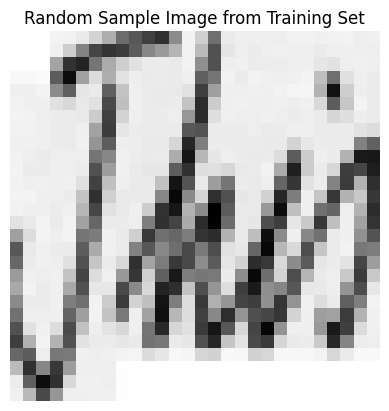

In [96]:
# Display a random sample from the training set
random_idx = np.random.randint(len(Y_train))  # Randomly select an index from the training set

# Find the corresponding original transcription using the encoded value
idx = np.where(df_filtered['transcription_encoded'].values == Y_train[random_idx])[0][0]  # Find the index in the DataFrame corresponding to the encoded label
print('Translation =', df_filtered['transcription'].iloc[idx])  # Print the original transcription

# Display the randomly selected sample image from the training set
plt.imshow(X_train[random_idx], cmap='gray')  # Display the image in grayscale
plt.title('Random Sample Image from Training Set')
plt.axis('off')  # Hide the axis for better visualization
plt.show()


* transforming data into 4-dimensional array (images, width, height, depth)
* One-hot encoding for labels

## Reshaping Data for CNN Input

In this step, we reshape the input images to ensure they are in the correct format for a Convolutional Neural Network (CNN). We reshape the data from `(28, 28)` to `(28, 28, 1)` to explicitly indicate that the images are grayscale with one channel. This is important for the CNN to correctly process the input.


In [97]:
# Reshape for CNN
# Reshape the input data to (28, 28, 1) where '1' represents the grayscale channel
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))


## Calculating Class Weights to Handle Class Imbalance

To deal with potential class imbalances in our training dataset, we calculate **class weights**. This step ensures that underrepresented classes are given more attention during training, thus improving overall performance and reducing bias towards majority classes.


In [98]:
# Calculate class weights manually based on class distribution
class_counts = np.unique(Y_train, return_counts=True)[1] # Count occurrences of each class
max_count = np.max(class_counts)
smooth_factor = 1e-6  # Small value to avoid division errors

# Calculate class weights to penalize majority classes and give minority classes more weight
class_weights_manual = class_counts / max_count
class_weights_manual += smooth_factor

# Create a dictionary mapping class labels to their respective weights
class_weights_dict_manual = {label: weight / np.sum(class_weights_manual) for label, weight in zip(np.unique(Y_train), class_weights_manual)}
print("Class Weights: ", class_weights_dict_manual)


Class Weights:  {0: 0.0620625135166647, 1: 0.04479702028198023, 2: 0.0648623232303973, 3: 0.06439568827810854, 4: 0.04573029018655776, 5: 0.03733086104535992, 6: 0.039197400854515, 7: 0.053663084375466845, 8: 0.05692952904148823, 9: 0.05039663970944547, 10: 0.045263655234269, 11: 0.05646289408919947, 12: 0.06066260865979838, 13: 0.04573029018655776, 14: 0.05179654456631177, 15: 0.042463845520536385, 16: 0.053196449423178076, 17: 0.03733086104535992, 18: 0.04946336980486792, 19: 0.038264130949937455}


## One-Hot Encoding Labels

For training the CNN, we need to **one-hot encode** the target labels. One-hot encoding transforms the class labels into binary matrices, making it easier for the model to compute losses and predictions correctly. This is a common practice for multi-class classification tasks.


In [99]:
# One-hot encoding the labels for training and testing sets
num_classes = max(len(np.unique(Y_train)), len(np.unique(Y_test)))  # Number of unique classes
y_train = to_categorical(Y_train, num_classes=num_classes)
y_test = to_categorical(Y_test, num_classes=num_classes)

# Verify the results of one-hot encoding
print("Shape of unique Y_train:", np.unique(Y_train).shape)  # Number of unique classes in Y_train
print("Shape of one-hot encoded y_train:", y_train.shape)  # Should have the same number of examples as X_train and columns equal to number of classes
print("Example of class label in y_train:", np.argmax(y_train[0]))  # Print the label of the first sample in y_train to check the one-hot encoding
print("Number of unique classes in Y_train:", len(np.unique(Y_train)))  # Should match the number of classes in one-hot encoded y_train


Shape of unique Y_train: (20,)
Shape of one-hot encoded y_train: (2143, 20)
Example of class label in y_train: 2
Number of unique classes in Y_train: 20


## Data Augmentation with ImageDataGenerator

To improve the generalization ability of the model, we apply data augmentation to the training images using `ImageDataGenerator`. Data augmentation helps the model become more robust by introducing variations that make it less likely to overfit the training data.

- **Training Data Augmentation**: We apply random transformations, such as width and height shifts, and rotations, to create a more diverse training set.
- **Testing Data**: The testing data is not augmented to ensure consistency during model evaluation.

### Parameters:
- **`width_shift_range`**: Randomly shift images horizontally by up to 10% of their width.
- **`height_shift_range`**: Randomly shift images vertically by up to 10% of their height.
- **`rotation_range`**: Randomly rotate images within a range of 5 degrees.

This step helps create augmented versions of the training data in real-time during model training.


In [111]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 5)

test_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow(X_train,y_train, batch_size = 64)
test_dataset = test_datagen.flow(X_test, y_test, batch_size = 64)

## Setting Up Early Stopping and Model Checkpoint Callbacks

In this step, we define two key callbacks to ensure efficient training of our deep learning model:

1. **Early Stopping**: Helps prevent overfitting by stopping the training process when the validation accuracy stops improving after a set number of epochs.
2. **Model Checkpoint**: Saves the model with the best performance on the validation set. This allows us to restore the best version of the model during training.

### Callback Parameters:
- **`patience`**: Defines how many epochs to wait for an improvement before stopping.
- **`min_delta`**: Minimum change required in the monitored metric to qualify as an improvement.
- **`mode` and `monitor`**: Define whether to monitor for increasing or decreasing values and which metric to track.
- **`save_best_only`**: If true, only saves the model when there is an improvement in the monitored metric.

Using these callbacks, we can ensure that the model stops training at the optimal point and that the best-performing version of the model is saved.

In [112]:
# Early Stopping and Model Checkpoint Callbacks

# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    patience=30,  # Wait 30 epochs for an improvement in the monitored metric before stopping
    min_delta=0.01,  # Minimum change in the monitored metric to be considered an improvement (1% change)
    verbose=1,  # Verbose mode to print messages about when training stops
    mode='min',  # Mode to minimize the monitored metric ('val_loss' or other decreasing metrics)
    monitor='val_accuracy'  # Monitor validation accuracy for early stopping
)

# Define ModelCheckpoint to save the best version of the model during training
model_checkpoint = ModelCheckpoint(
    filepath="../model_checkpoint/CNN.keras",  # Filepath to save the model checkpoint
    monitor="val_accuracy",  # Monitor validation accuracy to determine the best model
    save_best_only="True",  # Save the model only when there is an improvement in validation accuracy
    mode="max"  # Mode to maximize the monitored metric
)

## Building the Convolutional Neural Network (CNN)

In this step, we define a simple **Convolutional Neural Network (CNN)** model to recognize handwritten words. This architecture includes:
- **Convolutional Layer**: To extract features such as edges and textures.
- **Pooling Layer**: To reduce dimensionality and make the model more efficient.
- **Dropout Layer**: To prevent overfitting.
- **Fully Connected Layer**: To learn complex features and relationships.
- **Output Layer**: Using softmax activation for multi-class classification.


In [113]:
# Step 11: Define the CNN Model Architecture
inputs_cnn = Input(shape=(28, 28, 1))  # Input layer for grayscale images of size 28x28

# Convolutional Layer: Apply 32 filters of size 5x5 with ReLU activation
x = Conv2D(32, (5, 5), activation='relu')(inputs_cnn)

# Pooling Layer: Apply MaxPooling with a 2x2 window
x = MaxPooling2D(pool_size=(2, 2))(x)

# Dropout Layer: Apply dropout with rate 0.2 to reduce overfitting
x = Dropout(0.2)(x)

# Flatten the feature maps to prepare for the fully connected layer
x = Flatten()(x)

# Fully Connected Layer: 128 neurons with ReLU activation
x = Dense(128, activation='relu')(x)

# Output Layer: Apply softmax activation to predict the class
num_classes = y_train.shape[1]  # Number of unique classes in the dataset
outputs_cnn = Dense(num_classes, activation='softmax')(x)


## Compiling and Summarizing the CNN Model

In this step, we compile the CNN model and display a summary of its architecture. We use:
- **Loss Function**: Categorical cross-entropy, which is well-suited for multi-class classification problems.
- **Optimizer**: Adam optimizer, known for its adaptive learning rate, which helps in fast convergence.
- **Metrics**: Accuracy to evaluate the model's performance during training and validation.

We also display the model summary to verify the layers, output shapes, and the number of trainable parameters before proceeding with the training phase.


In [114]:
# Step 12: Compile the CNN Model
model_cnn = Model(inputs=inputs_cnn, outputs=outputs_cnn)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the CNN Model Summary
model_cnn.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 flatten_14 (Flatten)        (None, 4608)              0         
                                                                 
 dense_28 (Dense)            (None, 128)               589952    
                                                          

## Training the CNN Model

In this step, we train the CNN model using the prepared training dataset. During training:
- We use **early stopping** to prevent overfitting by stopping training if validation performance stops improving.
- **Model checkpoint** is used to save the best-performing model during training.
- **Class weights** are applied to handle class imbalance and ensure that underrepresented classes get appropriate focus.


In [115]:
# Train the CNN Model with Corrected Labels
training_history_cnn = model_cnn.fit(
    train_dataset, 
    epochs=100,  # Maximum number of epochs
    verbose=1,  # Verbosity mode
    class_weight=class_weights_dict_manual,  # Adjust class imbalance using class weights
    validation_data=test_dataset,  # Validation data
    callbacks=[early_stopping, model_checkpoint]  # Early stopping and model checkpoint callbacks
)


Epoch 1/100
34/34 [==============================] - 5s 63ms/step - loss: 0.1486 - accuracy: 0.1265 - val_loss: 2.7903 - val_accuracy: 0.2295
Epoch 2/100
34/34 [==============================] - 2s 57ms/step - loss: 0.1312 - accuracy: 0.2478 - val_loss: 2.3104 - val_accuracy: 0.3116
Epoch 3/100
34/34 [==============================] - 2s 67ms/step - loss: 0.1095 - accuracy: 0.3346 - val_loss: 1.8334 - val_accuracy: 0.4981
Epoch 4/100
34/34 [==============================] - 3s 74ms/step - loss: 0.0933 - accuracy: 0.4410 - val_loss: 1.6301 - val_accuracy: 0.5634
Epoch 5/100
34/34 [==============================] - 2s 65ms/step - loss: 0.0827 - accuracy: 0.5021 - val_loss: 1.4417 - val_accuracy: 0.5951
Epoch 6/100
34/34 [==============================] - 2s 55ms/step - loss: 0.0758 - accuracy: 0.5408 - val_loss: 1.3254 - val_accuracy: 0.6418
Epoch 7/100
34/34 [==============================] - 2s 58ms/step - loss: 0.0707 - accuracy: 0.5758 - val_loss: 1.2145 - val_accuracy: 0.6604
Epoch 

## Saving and Reloading the Trained Model

In this step, we save the trained VGG16 model to a file so that it can be easily reloaded in the future without the need to retrain. This is particularly useful when you want to use the model for inference or continue training at a later point.

### Steps:
1. **Save the Model**: Save the model, including its architecture, weights, and training configuration, using the `.h5` format.
2. **Reload the Model (Optional)**: If you want to load the saved model directly instead of training it from scratch, use the `load_model()` function.

In [ ]:
# Saving and Reloading the Trained Model

# Save the trained model to an H5 file
# This allows you to store the model's architecture, weights, and optimizer state in a single file
model_cnn.save("CNN.h5")
print("Model saved successfully.")

# OPTIONAL: Uncomment the following line to load the trained model without retraining
# This is useful for resuming training or for making predictions without retraining from scratch
#model_cnn = load_model("CNN.h5")
#print("Model loaded successfully.")

## Saving Training History as CSV

One convenient way to save the training history is by storing it in a CSV file.

In [ ]:
# Get the training history dictionary from the returned history object
history_dict = training_history_cnn.history

# Convert the dictionary to a DataFrame
history_df = pd.DataFrame(history_dict)

# Add the Epoch column (starting from 1 to the total number of epochs)
history_df.insert(0, 'Epoch', range(1, len(history_df) + 1))

# Save the DataFrame to a CSV file
csv_file_path = 'CNN_training_history.csv'
history_df.to_csv(csv_file_path, index=False)

## Plotting Training and Validation Accuracy Curves

In this step, we visualize the **training** and **validation accuracy** over the course of training. This helps in understanding how well the model is learning and whether it is overfitting or underfitting:
- **Training Accuracy**: Measures how well the model is fitting to the training data.
- **Validation Accuracy**: Measures the model's performance on unseen validation data, which helps in understanding its generalization ability.

If training accuracy keeps improving while validation accuracy plateaus or declines, it may indicate **overfitting**.

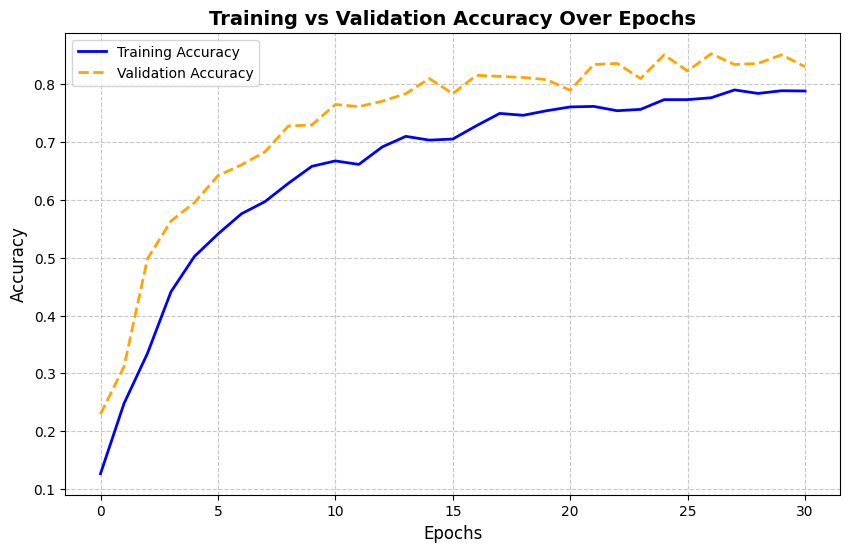

In [117]:
# Extract training and validation accuracy from the training history
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))  # Set the figure size for better visualization
plt.plot(train_acc_cnn, label='Training Accuracy', color='blue', linewidth=2)  # Training accuracy in blue
plt.plot(val_acc_cnn, label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)  # Validation accuracy in dashed orange

# Add axis labels and title
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')

# Add legend to differentiate between training and validation curves
plt.legend(loc='best')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


## Step 16: Evaluating Model Performance with Classification Report

In this step, we evaluate the **performance of the trained CNN model** on the test set. We use the **classification report** from scikit-learn to compute the following metrics:
- **Precision**: Measures how many of the predicted positive instances are actually positive.
- **Recall**: Measures how many of the actual positive instances are correctly predicted.
- **F1-Score**: The harmonic mean of precision and recall, providing a single measure of model quality.

These metrics provide an overall assessment of how well the model is generalizing to new, unseen data.

In [118]:
# Step 16: Predicting on the Test Set and Evaluating Performance
# Get model predictions for the test set
test_pred = model_cnn.predict(X_test)

# Convert predicted probabilities to class labels
test_pred_class = test_pred.argmax(axis=1)
y_test_class = y_test.argmax(axis=1)

# Generate the classification report as a dictionary
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)

# Extract mean values for weighted average metrics
mean_precision = report['weighted avg']['precision']
mean_recall = report['weighted avg']['recall']
mean_f1_score = report['weighted avg']['f1-score']

# Print the extracted metrics in a well-formatted manner
print("Classification Report Summary:")
print(f"Mean Precision: {mean_precision:.2f}")
print(f"Mean Recall: {mean_recall:.2f}")
print(f"Mean F1-Score: {mean_f1_score:.2f}")


17/17 [==============================] - 0s 4ms/step
Classification Report Summary:
Mean Precision: 0.84
Mean Recall: 0.83
Mean F1-Score: 0.83


## Save Predicted Data

In [ ]:
# Flatten X_test if it is a 3D image data (height, width, channel) for saving as CSV
X_test_flattened = X_test.reshape(len(X_test), -1)


# Create DataFrame and save
df_X_test = pd.DataFrame(X_test_flattened)
df_y_test = pd.DataFrame(y_test_class, columns=['label'])

# Save as CSV
df_X_test.to_csv('CNN_X_test.csv', index=False)
df_y_test.to_csv('CNN_y_test.csv', index=False)
'''
# Load X_test and y_test from CSV files
df_X_test = pd.read_csv('CNN_X_test.csv')
df_y_test = pd.read_csv('CNN_y_test.csv')

# Convert back to NumPy arrays if needed
X_test = df_X_test.values.reshape(-1, 28, 28, 1)  # Adjust shape as necessary
y_test_class = df_y_test['label'].values
'''

## Visualizing the Confusion Matrix with Seaborn

To better understand the classification results, we visualize the confusion matrix using Seaborn's heatmap. The confusion matrix shows how well the model performed for each class by displaying the counts of true vs. predicted labels.

Using Seaborn, we can:
- **Visualize Counts with Color Gradient**: The intensity of the color in each cell helps us quickly see where the model is performing well and where it may need improvement.
- **Display Annotations**: Each cell displays the exact count, making it easier to interpret the results.

The confusion matrix allows us to identify specific classes that the model finds challenging to distinguish.

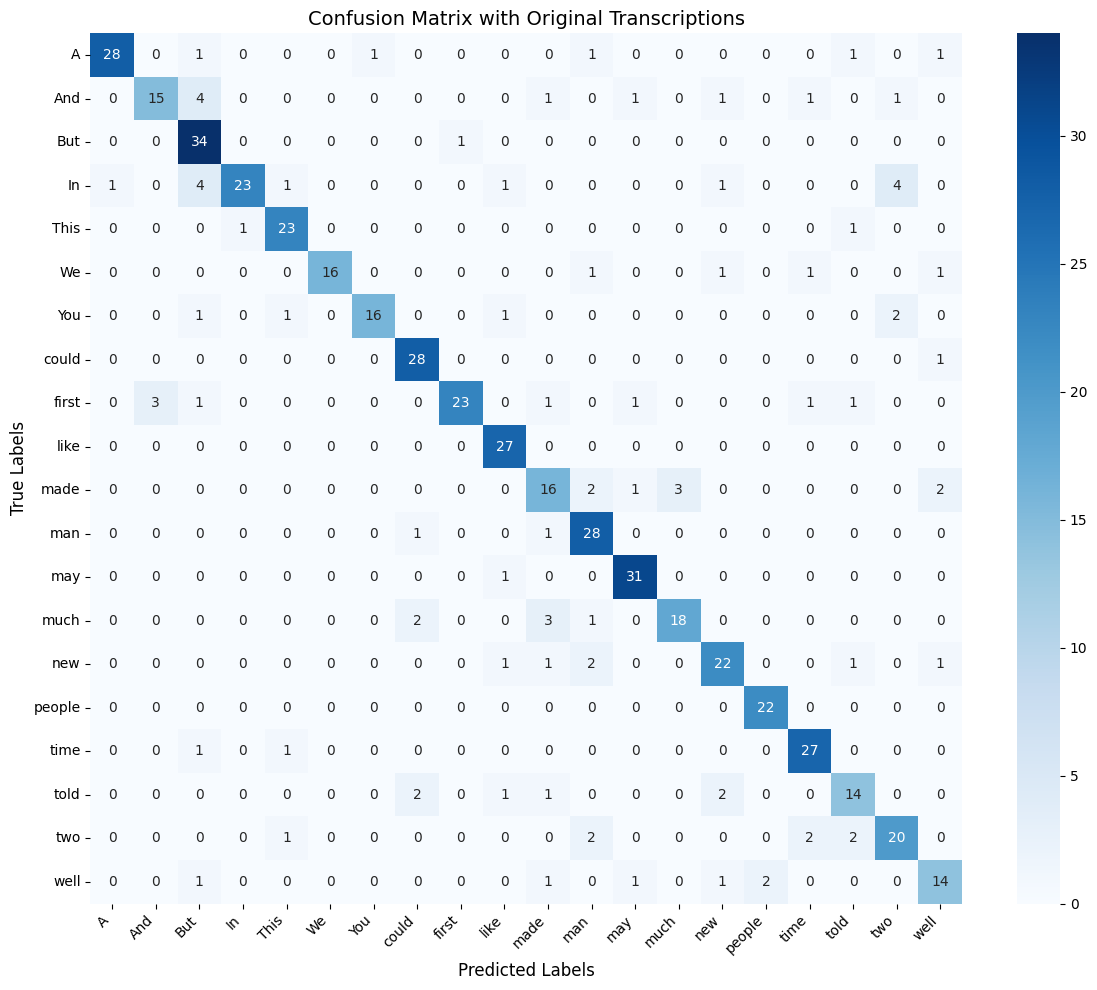

In [119]:
# Visualizing the Confusion Matrix with Original Transcriptions

# Generate the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

# Retrieve the original transcriptions for the labels using the LabelEncoder
original_labels = le.classes_

# Plot the confusion matrix using Seaborn heatmap with original transcription labels
plt.figure(figsize=(12, 10))  # Set the figure size for better readability
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=original_labels, yticklabels=original_labels)  # Use original labels for better interpretability

# Add labels, title, and layout adjustments
plt.xlabel('Predicted Labels', fontsize=12)  # Label for x-axis
plt.ylabel('True Labels', fontsize=12)  # Label for y-axis
plt.title('Confusion Matrix with Original Transcriptions', fontsize=14)  # Add a title
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure all elements are visible without overlap

# Show the plot
plt.show()


## Visualization of Misclassified Images

To gain insights into model performance, we visualize some of the misclassified images from the test dataset. This enhanced visualization allows us to:
- **Understand Model Errors**: Identify common errors and which transcriptions the model tends to misclassify.
- **Evaluate Confidence**: See how confident the model was when it made incorrect predictions.

### Visualization Elements:
1. **True vs. Predicted Transcription**: For each misclassified image, we display the true and predicted labels.
2. **Confidence Score**: The confidence level of the incorrect prediction is displayed, helping us understand if the model was overconfident about the wrong answer.

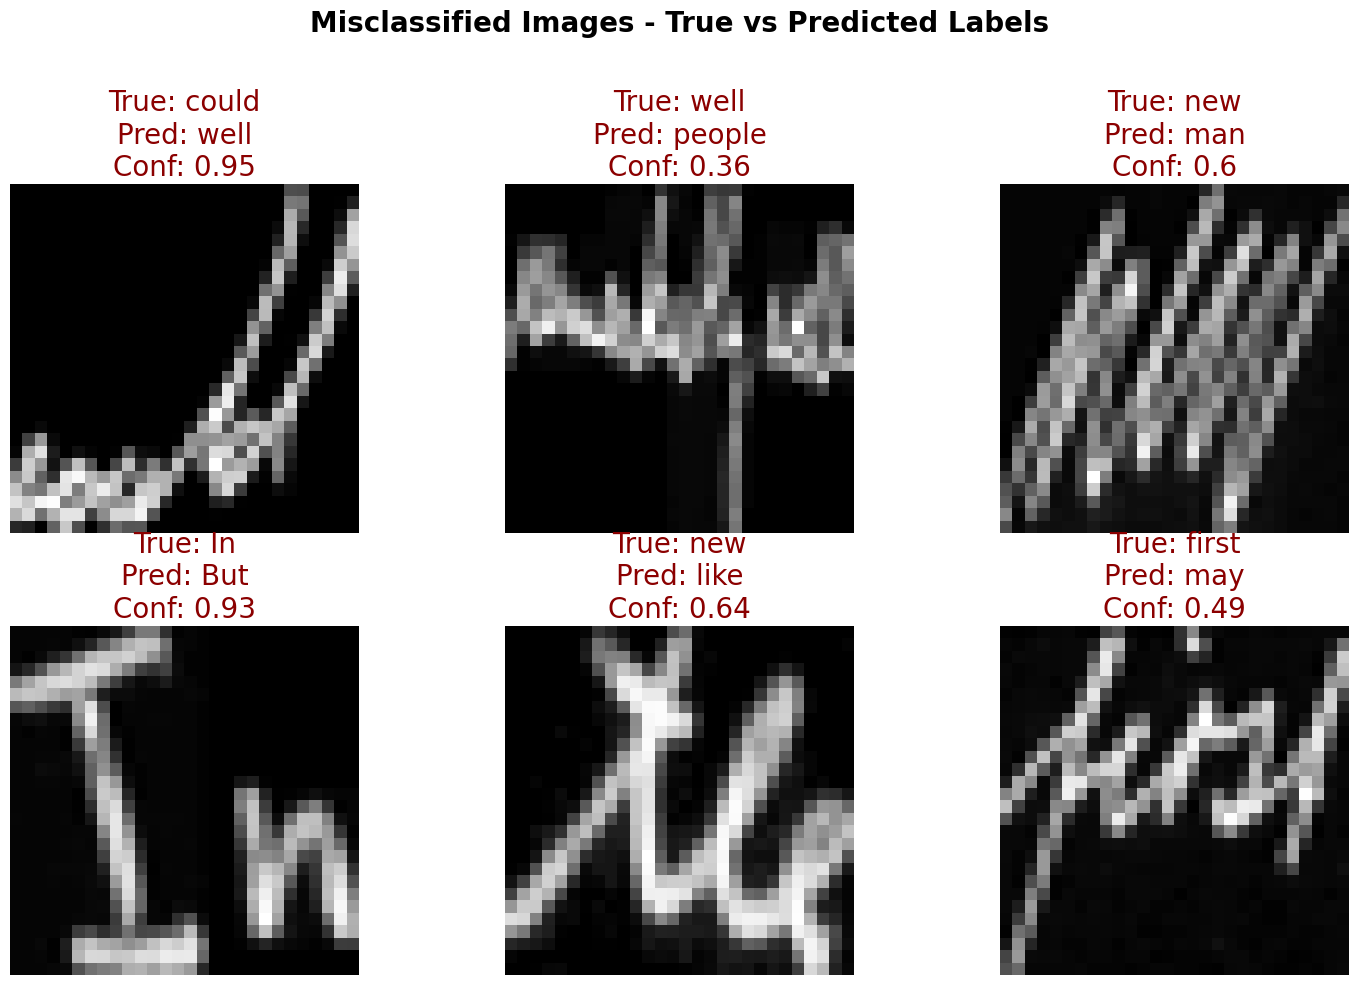

In [120]:
# Enhanced Visualization of Misclassified Images

# Create a mapping from class indices to original transcriptions
class_mapping = {index: transcription for index, transcription in enumerate(pd.Series(Y).unique())}

# Identify indexes where the model made incorrect predictions
error_indexes = [i for i in range(len(test_pred)) if test_pred_class[i] != y_test_class[i]]

# Check if there are any misclassifications
if len(error_indexes) > 0:
    # Determine the number of misclassified images to display (up to 6)
    num_images = min(6, len(error_indexes))
    
    # Set up the plot for displaying misclassified images in a grid layout
    plt.figure(figsize=(15, 10))  # Set figure size for better visibility
    grid_cols = 3  # Number of columns in the grid
    grid_rows = (num_images + grid_cols - 1) // grid_cols  # Number of rows in the grid

    for j, i in enumerate(np.random.choice(error_indexes, size=num_images, replace=False)):
        img = X_test[i]  # Extract the misclassified image

        # Create subplot to display the image in the grid layout
        plt.subplot(grid_rows, grid_cols, j + 1)
        plt.axis('off')  # Hide axes for better visualization
        plt.imshow(img, cmap=cm.binary)  # Display the image in grayscale

        # Get the true and predicted transcriptions for the misclassified image
        true_transcription = df_filtered.loc[df_filtered['transcription_encoded'] == Y_test[i], 'transcription'].iloc[0]
        predicted_transcription = df_filtered.loc[df_filtered['transcription_encoded'] == test_pred_class[i], 'transcription'].iloc[0]
        confidence = str(round(test_pred[i][test_pred_class[i]], 2))  # Get the confidence score for the predicted class

        # Add a title to each subplot with True label, Predicted label, and Confidence score
        plt.title(f'True: {true_transcription}\nPred: {predicted_transcription}\nConf: {confidence}',
                  fontsize=20, color='darkred')  # Use red color to highlight misclassification
    
    # Adjust layout to make sure everything is clearly visible
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Add spacing between images to avoid overlap
    plt.suptitle('Misclassified Images - True vs Predicted Labels', fontsize=20, color='black', weight='bold')  # Add a title to the whole plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid overlap with the super title
    plt.show()
else:
    print("No errors in predictions.")  # Print if no errors in predictions


## Predicting on Custom Handwritten Images

In this step, we use the trained model to predict handwritten images from a custom folder (`my_handwriting`). We loop through each image, preprocess it, and use the model to predict the transcription.

### Steps:
1. **Load Images from Folder**: Load each image from the specified folder containing custom handwritten images.
2. **Preprocess Images**: Resize and prepare each image for input to the model.
3. **Model Prediction**: Predict the transcription for each image and calculate the confidence of the prediction.
4. **Store Results**: Store the true label, predicted label, and confidence for each image in a DataFrame for easy visualization.

This helps evaluate how well the model performs on new, unseen handwritten images.

In [122]:

# Folder with handwritten images
folder_path = '../../my_handwriting' # adjust the path to your own hand written words here
results = []

# Loop through each image in the folder
for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    
    # Load and preprocess image to match the CNN input (grayscale, 28x28)
    img = image.load_img(img_path, color_mode='grayscale', target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize if needed
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict
    predictions = model_cnn.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = round(np.max(predictions) * 100, 2)  # Confidence as percentage
    
    # Get predicted and true labels
    predicted_label = le.inverse_transform([predicted_class])[0]
    true_label = img_name.split('.')[0]  # Assuming filename is the word
    
    # Append result to list
    results.append({
        'Image': img_name,
        'True Label': true_label,
        'Predicted Label': predicted_label,
        'Confidence (%)': confidence
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


1/1 [==============================] - 0s 55ms/step
         Image True Label Predicted Label  Confidence (%)
0        A.jpg          A             man           28.52
1      And.jpg        And             man           13.89
2      But.jpg        But             man           30.51
3    could.jpg      could             man           38.67
4    first.jpg      first           first           45.61
5       In.jpg         In             But           25.99
6     like.jpg       like            like           26.17
7     made.jpg       made            made           18.68
8      man.jpg        man             man           80.55
9      may.jpg        may             may           84.83
10    much.jpg       much            much           14.69
11     new.jpg        new            made           18.65
12  people.jpg     people          people           57.52
13    This.jpg       This             man           28.16
14    time.jpg       time            time           31.67
15    told.jpg      

## Visualizing Prediction Confidence for Each Handwritten Image

To gain further insights into the model's predictions, we plot the confidence level for each handwritten image from the custom dataset. This visualization helps in:

1. **Understanding Model Confidence**: See how confident the model was in its predictions for each image.
2. **Identifying Correct vs. Incorrect Predictions**: Correct predictions are shown in green, while incorrect ones are shown in red, making it easy to visually distinguish the two.

This can help identify images that the model was unsure of and may benefit from further improvements or retraining.


In [123]:
# Assuming results_df is already defined and contains prediction results

# Sort results by confidence for better visualization
results_df = results_df.sort_values(by="Confidence (%)", ascending=False)

# Determine colors for each bar based on whether the prediction was correct
colors = ['green' if row['True Label'] == row['Predicted Label'] else 'red' for index, row in results_df.iterrows()]

# Create a Plotly figure for better interactive visualization
fig = go.Figure()

# Add horizontal bar chart with color-coding based on prediction correctness
fig.add_trace(go.Bar(
    y=results_df['Image'],
    x=results_df['Confidence (%)'],
    orientation='h',
    marker=dict(color=colors),
    text=[
        f"Pred: {row['Predicted Label']}<br>True: {row['True Label']}"
        if row['True Label'] != row['Predicted Label']
        else f"Pred: {row['Predicted Label']}"
        for _, row in results_df.iterrows()
    ],
    hoverinfo='text'
))

# Update layout for better visibility
fig.update_layout(
    title="Prediction Confidence for Each Image",
    xaxis_title="Confidence (%)",
    yaxis_title="Image",
    yaxis=dict(autorange="reversed"),  # Invert y-axis (highest confidence at the top)
    height=800,  # Set figure height for better visibility
    width=1000,
    template='plotly_white',
    legend=dict(x=0.85, y=1.15),
)

# Display the figure
fig.show()
